<a href="https://www.kaggle.com/code/afi1289/twitter-analysis-house-of-the-dragon?scriptVersionId=113379716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-family:verdana;"> <center> House Of The Dragon 🐉 Twitter Analysis 🔥 </center> </h1>
<p><center style="color:#159364; font-family:cursive;">Strive for Excellence, Not Perfection</center></p>

***

<h1 style='background:#00aaee; border:0; border-radius: 10px; color:white'><center> TABLE OF CONTENTS </center></h1>

### [1.Importing Libraries](#title-one)

### [2.Store and Retrieve your Individual Secrets](#title-two)

### [3.Connect with Twitter API v2](#title-three)
    
### [4.Build the Dataset](#title-four) 

### [5.Update your Dataset Automatically](#title-five) 

### [6.Get Familiar with your Dataset](#title-six)

### [7.Build Text Preprocessing Pipeline](#title-seven)

<a id="title-one"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>Importing Libraries</center></h1>

Now, we can install `tweepy` and import the libraries:

In [ ]:
! pip install tweepy

In [ ]:
# install textacy
!pip install textacy

In [ ]:
# import libraries 
import pandas as pd

pd.set_option('display.max_colwidth', None) 
pd.options.mode.chained_assignment = None

# visualization using plotly
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

%matplotlib inline
import numpy as np
import tweepy

import warnings
warnings.filterwarnings('ignore')

<a id="title-two"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>Store and Retrieve your Individual Secrets</center></h1>


I'm using Secrets feature in this notebook. When you use this feature to store and retrieve your secrets we ensure that **only** your Notebook can access the credential. So, if another user forks your public notebook they’ll need to **enter their own** individual secrets to match your implementation.

Once you have added the Keys to your Notebook, you can copy and paste to access your secret with the code below:

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
ACCESS_TOKEN = user_secrets.get_secret("access_token")
ACCESS_TOKEN_SECRET = user_secrets.get_secret("access_token_secret")

API_KEY = user_secrets.get_secret("api_key")
API_SECRET = user_secrets.get_secret("api_secret")
BEARER_TOKEN = user_secrets.get_secret("bearer_token")

<a id="title-three"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>Connect with Twitter API v2</center></h1>

Let's make a connection with the Twitter API:

In [ ]:
client = tweepy.Client(bearer_token = BEARER_TOKEN,
                       consumer_key = API_KEY,
                       consumer_secret = API_SECRET,
                       access_token = ACCESS_TOKEN,
                       access_token_secret = ACCESS_TOKEN_SECRET)

* In order to get Tweets for your purpose using the Twitter API, you need to specify what Tweets you are looking for. To do so, you need to write a **search query**, which gives you the ability to describe the keywords and conditions for which you want Tweets.
* A **search query** or rule can consist of a combination of standalone operators such as keywords and conjunction-required operators such as `is:retweet`.
* We pass the search query `search_query` to the `client` object and additionally include more information with `tweet_fields` (author ID and when the Tweet was created).

In [ ]:
# define your search query
# get tweets that contain "House of the Dragon" or relevant hashtags, given they are in English and NOT retweets, reply, or quote
search_query = '"House of the Dragon" OR #HOTD OR "#HouseOfTheDragon" OR #hotd lang:en -is:retweet -is:reply -is:quote'

In [ ]:
new_tweets_df = pd.DataFrame()

for tweet_batch in tweepy.Paginator(client.search_recent_tweets,
                                    search_query, 
                                    expansions=['author_id'],                   # enable you to request additional data objects
                                    user_fields=['username'],                   # NOTE: use the author_id expansion if you want the username
                                    tweet_fields=["public_metrics,created_at"], # list without space between elements or as before
                                    max_results=100,                            # maximum number of search results to be returned by a request
                                   limit=50):                                   # maximum number of requests
    data = tweet_batch.data
    users = tweet_batch.includes['users']
    users_df = pd.DataFrame(users)
    try:
        users_df.columns = ['author_id','author_name','author_username']
        data_df = pd.DataFrame(data)
        tweet_batch_df = users_df.merge(data_df, on="author_id")
        new_tweets_df = new_tweets_df.append(tweet_batch_df,ignore_index=True)
    except:
        pass

In [ ]:
new_tweets_df.rename(columns={"id": "tweet_id"}, inplace=True)

In [ ]:
new_tweets_df

<a id="title-four"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>Build the Dataset</center></h1>

Now we can save the dataframe into a `csv` file to build the core dataset: 

> **NOTE**: The cell below must be **activated** in the **first** Save & Run All (Commit) **only**. In addition, the cell in the next section should be **deactivated** in the first run.

In [ ]:
# build the dataset
# only for the first run
#new_tweets_df.to_csv('twitter_HOTD.csv', header=["author_id","author_name","author_username",
#                                               "created_at","tweet_id","public_metrics","text"], index=False,)

<a id="title-five"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>Update your Dataset Automatically</center></h1>

Now, we will use an amazing Kaggle feature to update our dataset **automatically** from the notebook’s output (i.e., with every time you run a fresh copy of your notebook and save the output “Save & Run All”). All you need to do is to create a new dataset from the notebook viewer page and synchronize it with the new notebook versions. Check out [this post](https://www.kaggle.com/product-feedback/293761) for more illustration.

> **NOTE**: The cell below must be **deactivated** in the **first run**, You have to **activate** it after scheduling your notebook or when you Save & Run All (Commit) 

To schedule your notebook run, go the settings menu of the notebook editor, schedule the notebook to update either daily, weekly, or monthly.

In [ ]:
try:
#    del new_tweets_df["withheld"]
    del new_tweets_df['edit_history_tweet_ids']
except:
    pass

In [ ]:
#new_tweets_df.columns

In [ ]:
# get old tweets
old_tweets_df = pd.read_csv("../input/hotdtweets/twitter_HOTD.csv")

# merge old tweets with new 
updated_tweets = pd.concat([new_tweets_df, old_tweets_df]).drop_duplicates(subset="tweet_id") #subset="text"

# save the merged data into csv file
updated_tweets.to_csv("twitter_HOTD.csv", header=["author_id","author_name","author_username",
                                                 "created_at","tweet_id","public_metrics","text"], index=False)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; If you find this notebook useful in anyway, please upvote it so that it can reach a bigger audience 🔥. You can share it with your fellow kagglers.
</div>

<a id="title-six"></a>
<h1 style='background:#00aaee; border:2; border-radius: 10px; color:white'><center>GET FAMILIAR WITH YOUR DATASET</center></h1>

Before starting the real analysis, let's gather some information about the structure of our dataset:

In [ ]:
df = pd.read_csv("./twitter_HOTD.csv", engine= "python")

# add new column with tweet's length
df['length'] = df['text'].str.len()

# compute the summary statistics for the columns
df[["length"]].describe().T


In [ ]:
df

In [ ]:
df[["author_username", "text"]].describe(include="O").T

### Check for Missing Values:

In [ ]:
try:
    df.dropna(inplace=True)
except:
    pass

In [ ]:
# show the number of NaN in each column
df.isnull().sum()

No missing values to handle 😊!

Order by high likes but first you have to create new column from public_metrics (see https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary)

In [ ]:
import json

# convert string representation of dict to a dict
df["public_metrics"] = df["public_metrics"].apply(lambda x: x.replace("'", "\""))
df["public_metrics"] = df["public_metrics"].apply(lambda x: json.loads(x))

# add new columns from public metrics
for key in df['public_metrics'][0].keys():
    df[key] = df['public_metrics'].str[key]
    #or 
    # df[key] = df['public_metrics'].get(key)

In [ ]:
df.sort_values(by=['like_count'], ascending = False)

### Language Detection with fastText

In the search query, we've already specified tweets language to be English. However, we can see some non-English tweets. Let's use fastText to detect tweets language. For this purpose, we'll use a small model `lid.176.ftz`:

In [ ]:
# download model
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

In [ ]:
import fasttext

lang_model = fasttext.load_model("lid.176.ftz")

# make a prediction
lang_model.predict('"Good morning" in German is "Guten Morgen"', 3)

The predict function takes two arguments:

1. Unicode string.
2. Optional parameter `k` specifies that we want the `k` language labels with the highest probabilities.

The model returns labels in the form `__label__<code>`, i.e., language label and the corresponding probability. Let's wrap the language identification into a preprocessing function. The function returns the detected language only if the calculated probability is higher than the specified threshold, otherwise, it returns the default language:

In [ ]:
import fasttext
def predict_language(text, threshold=0.8, default='en'):

    # fasttext requires single line input
    text = text.replace('\n', ' ')
    
    
    labels, probas = lang_model.predict(text)
    lang = labels[0].replace("__label__", "") # remove __label__
    proba = probas[0]
    
    if proba < threshold:
        return default
    else:
        return lang

In [ ]:
# create new columns for tweet and name language
df['language_tweet'] = df['text'].apply(predict_language)

# check Non-English tweets 
df[df["language_tweet"]!="en"].head()

In [ ]:
# filter non-English tweets
df = df.query("language_tweet == 'en'") # same as df[df["language_tweet"] == "en"]

Let's find most popular characters in the tweets:

In [ ]:
# add dummy variable for main characters
characters = ["Rhaenyra","Daemon","Alicent","Corlys","Criston","Viserys","Otto","Laenor","Mysaria","Aemond","Ser Harrold"]

# find tweets that mention each character
for charcter in characters:
    df[charcter] = df["text"].str.contains(charcter, case=False).astype(int)

In [ ]:
import plotly.graph_objects as go

colors = ["#05000E","#BE0303","#007853","#FFF5F1","#FFC75F","#F9F871","#9BDE7E","#4BBC8E","#039590","#1C6E7D","#2F4858"]

fig = go.Figure([go.Bar(x=characters, 
                        y=df[characters].sum())])

# Customize aspect
fig.update_traces(marker_color=colors, 
                  marker_line_color='#08306B',
                  marker_line_width=1.5, 
                  opacity=0.6)
fig.update_layout(title_text='Most Popular Characters', 
                  width=800,
                  height=400,
                  autosize=True,
                  margin=dict(t=0, b=0, l=0, r=0),
                  template="plotly_white")
fig.show()

### Visualizing Developments over Time:
Since our dataset contains time element, it is worth visualizing some trends over the time. For example, let's see how the number of tweets changes every day:

In [ ]:
# create date column and sort by date
df["date"] = pd.to_datetime(df['created_at']).dt.date
df.sort_values(by="date", inplace = True)

> **NOTE**: You may show or hide traces by clicking or double-clicking on their associated legend item. Therefore, dropdown is not necessary here 😃

In [ ]:
fig = go.Figure()

for character,color in zip(characters,colors):
    
    y = df[df[character] == 1].groupby("date").size()
    
    fig.add_trace(go.Scatter(x = df["date"].unique()
                             , y = y,
                             mode = 'lines+markers',
                             name = character,
                            line_color = color))
    



#fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))
fig.update_layout(
    legend=dict(y=0.5, traceorder='reversed', font_size=16),
    title_text='Daily Tweets about Characters', 
    width=1400,
    height=600,
    template="plotly", # or seaborn, ggplot2, simple_white, presentation...
    
    updatemenus=[
        dict(
            buttons=[dict(args= [{'visible': [ True if x == character else False for x in characters  ]},
                                 {'title': character,
                                  'showlegend':True}],
                          label= character,
                          method= "update") 
                     for character in characters]
        )
    ]
)

fig.show()

Alicent was more popular after the royal wedding welcome feast 🔥

<a id="title-seven"></a>
<h1 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Build a Text Preprocessing Pipeline</center></h1>

* The **main goal** of any text preprocessing pipeline is to create a **prepared dataset** for analysis or feed it into a machine learning model. 
* For detailed explaination, check out my work in [First Step in your NLP Project (twitter dataset)](https://www.kaggle.com/code/afi1289/first-step-in-your-nlp-project-twitter-dataset)

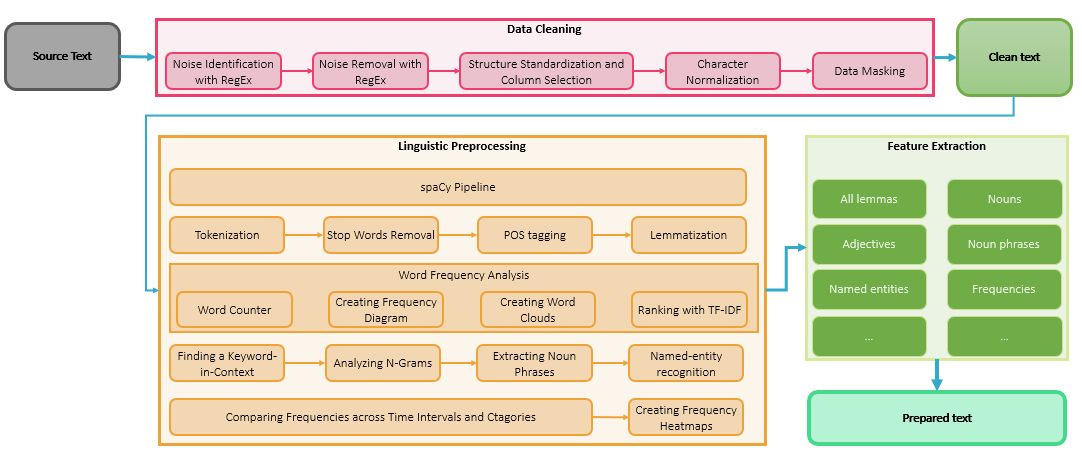

<a id="title-three"></a>
<h2 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Data Cleaning</center></h2>

In order to create a **prepared dataset** we have to clean our text. The first step in data cleaning is to remove unwanted characters. That is, delete all tags, HTML entities, and special characters. Here is where regular expressions can help.

#### Noise removal with RegEx:
To clean text data we will apply a set of RegEx to convert problematic patterns into characters or spaces. In addition, it will remove any non-English characters. If you want to test the RegEx on a specific text or develop your own RegEx, check this [Online Tool](https://regex101.com/).

In [ ]:
# define noise removal function
import html
import re

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

Let's apply `clean()` function on our dataframe:

In [ ]:
# create new column with map function, which accepts our clean function
df["clean_text"] = df["text"].apply(clean)

df[["text","clean_text"]].head()

#### Character normalization:
In this step, we will use `textacy` NLP library to replace **umlauts** (e.g., *schön*), **accents** (*è, â, î or ô*), **fancy characters/quotation marks** (𝔄𝔥𝔪𝔞𝔡 𝔄𝔩𝔦𝔰𝔪𝔞𝔦𝔩) with standard characters according to ASCII encoding format. In addition, words that have been split across lines by a hyphen for visual consistency would be joined.`textacy` allows composing multiple preprocessing steps into a single callable pipeline. Let's define a callable pipeline that takes a text as input, passes it through one or more functions in **sequential order**, then outputs a single (preprocessed) text string. 
> **NOTE:** To specify arguments for individual preprocessors, you can use `functools.partial()`:

In [ ]:
import textacy
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,
    
    
    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,
    
    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " "]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    #preprocessing.replace.emojis,
    
 )

In [ ]:
# apply on dataframe
df["clean_text_textacy"] = df["clean_text"].apply(preproc)

In [ ]:
df[["text", "clean_text_textacy"]].head()

<a id="title-six"></a>
<h2 style='background:#FF7F0E; border:2; border-radius: 10px; color:black'><center>Linguistic Processing</center></h2>

The second block in our preprocessing pipeline is linguistic processing, which consists basically of multiple steps, such as Tokenization, Stop Words Removal, Part-Of-Speech (POS) tagging, Lemmatization, Word frequency Analysis, and Named-Entity-Recognition (NER). For this purpose, we will use `spaCy`:


In [ ]:
import spacy
# download best-matching version of specific model for your spaCy installation
!python -m spacy download en_core_web_sm

In [ ]:
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_sm")

### Tokenization:

In `spaCy`, we can create our own tokenizer with our own customized rules.  To apply the tokenizer on a column in dataframe, we will use pandas `.apply()` function:

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

# customize your spaCy tokenizer
def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

# change the behaviour of nlp tokenizer
nlp.tokenizer = custom_tokenizer(nlp)

In [ ]:
df["tokens"] = df["clean_text_textacy"].apply(lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')])

### Stopwords Removal

In [ ]:
# the current set of stop words in spaCy
stopwords = nlp.Defaults.stop_words

# create a column of tokenized words that are NOT stop words or punctuations
# filter hashtags and retweet symbols
df["tokens_clean"] = df["clean_text_textacy"].apply(lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')
                                                                                               and not t.text == "RT"
                                                                                               and not t.is_stop 
                                                                                               and not t.is_punct])

Let's create new column containing hashtags only. Therefore, we will define a simple function for this purpose:

In [ ]:
def extract_hashtags(s):
    return [part[1:] for part in s.split() if part.startswith('#')]

In [ ]:
df["hashtags"] = df["clean_text_textacy"].map(extract_hashtags)

### Word Frequency Analysis:
In this step we will **calculate** and **visualize** word/hashtags frequencies. In addition, we visuaize these frequencies by different font sizes (i.e., **word clouds**). 

In [ ]:
from collections import Counter 

# count words in a column of dataframe and return dataframe
def count_words(df_name, column_name, preprocess=None, min_freq=2):

    # define inner function to process tokens and update counter
    def inner_update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens) # update here is counter method

    # create counter and run through all data
    counter = Counter()
    df_name[column_name].map(inner_update) # call inner function

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    # query the columns of a DataFrame with a boolean expression
    freq_df = freq_df.query('freq >= @min_freq')
    # change the index name
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [ ]:
# calculate the frequency of words in the precomputed "tokens_clean" column
freq_df = count_words(df, "tokens_clean")

# create frequency diagram
freq_df.head(10).plot(kind="barh",
                      labels={"value" : "Frequency", "token":"Token"},
                      title= "Top Tokens")

In [ ]:
# calculate the frequency of words in the precomputed "hashtags" column
freq_hashtags = count_words(df, "hashtags")

freq_hashtags.head(10).plot(kind="barh",
                      labels={"value" : "Frequency", "token":"Hashtag"},
                      title= "Top Hashtags",)

We can also use `plotly.graph_object` for more customized bar plot:

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2,
                   subplot_titles=("Top Words", "Top Hashtags"))

fig.add_trace(go.Bar(x =  freq_df["freq"][:10],
                     y =  freq_df.index.values[:10] , 
                     orientation='h',               # horizontal bar plot
                     marker_color= '#FF7F0E',       # Changing color of Bars
                     marker_line_color = '#F9545F', # Changing color of border
                     marker_line_width = 2,         # Changing width of border
                     opacity=0.7,                    # Changing opacity of Bars
                    ),
              row=1, col=1
             )

fig.add_trace(go.Bar(x =  freq_hashtags["freq"][:10],
                     y =  freq_hashtags.index.values[:10] , 
                     orientation='h',               # horizontal bar plot
                     marker_color= '#CA4F8C',       # Changing color of Bars
                     marker_line_color = '#845798', # Changing color of border
                     marker_line_width = 2,         # Changing width of border
                     opacity=0.7,                    # Changing opacity of Bars
                    ),
              row=1, col=2
             )

# we use update_layout() method to update multiple nested nested properties of a figure's layout
fig.update_layout(
    title='Top Words and Hashtags',                             # change the title
    yaxis=dict(                                    # customize yaxis
                title='Token',                    
                titlefont_size=16,
                tickfont_size=14,
                ),
   
    xaxis=dict(                                    # customize xaxis for subplot 1
                title='Word Frequency',
                titlefont_size=16,
                tickfont_size=14,
                ),
    xaxis2=dict(                                   # customize xaxis for subplot 2
        title='Hashtag Frequency',
        titlefont_size=16,
        tickfont_size=14,
                ),
    width=1200,
    height=650,
    margin=dict(                                   # set margins for left, right, bottom, and top
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)', # Sets the background color of the paper where the graph is drawn
    plot_bgcolor='rgb(243, 243, 243)',  # Sets the background color of the plotting area in-between x and y axes
    
    showlegend=False,
)

fig.show()


### Creating Word Clouds
Word Clouds allow identifiying the keywords in a text where words. The more a specific word appears in a piece of text, the bigger and bolder it appears in the word cloud.

In [ ]:
from wordcloud import WordCloud 
from collections import Counter
from matplotlib import pyplot as plt

def WC_generator(word_freq, title=None, max_words=200, stopwords=None):
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
        
    # create wordcloud object
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    # generate word cloud image from frequencies
    wc.generate_from_frequencies(counter)
 
    # Display the cloud using matplotlib 
    plt.figure(figsize=(20,10))
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [ ]:
WC_generator(freq_df['freq'], max_words=200)

In [ ]:
# same frequency series defined before
# generate pandas series of frequencies from the "clean_text_textacy" column 
# preprocess has function to tokenize words and filter hashtags., stop words, and punctuations
freq_df_RH = count_words(df.query("Rhaenyra == 1"), 
                           "clean_text_textacy", 
                           preprocess = lambda x: [t.text for t in nlp.tokenizer(x) if not t.text.startswith('#')
                                                                                    and not t.text == "RT"
                                                                                    and not t.is_stop 
                                                                                    and not t.is_punct])

# create a word cloud directly from frequencies using WC_generator function
WC_generator(freq_df_RH['freq'], max_words=50)

### Analyzing N-grams
It can be helpful to extend **frequency analysis** from single words **to short sequences** of two or three words.

We usually work with **bigrams** (sequence of length 2), **trigrams** (length 3). **n-grams** of size 1 are **unigrams** (single words). The function below creates a set of bigrams for a sequence of tokens. Basically, most of the bigrams will contain stop words. This function build therefore bigrams and keep those **without** stop words:

In [ ]:
# define a function to build a list of n-grams from with a specific length from a list of tokens
# it accepts a set of stopwords and a seperator
def ngrams(tokens, length=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(length)])
            if len([t for t in ngram if t in stopwords])==0] # to ensure that we don't have any stopword in ngram

In [ ]:
df["bigrams"] = df["tokens_clean"].apply(ngrams, length=2, stopwords=stopwords)

# find the most frequent bigrams
bigram_df = count_words(df, "bigrams")

# create a word cloud directly from frequencies using WC_generator function
WC_generator(bigram_df['freq'], max_words=30)

<div style="padding:20px;color:black;margin:0;font-size:250%;text-align:center;display:fill;border-radius:5px;background-color:#aaf0f0;overflow:hidden;font-weight:700;border: 5px solid #21a3a3;">  📌 &nbsp; If you find this notebook useful in anyway, please upvote it so that it can reach a bigger audience 🔥. You can share it with your fellow kagglers. </div>